In [1]:
%load_ext autoreload
%autoreload 2

import random
import numpy as np
import pandas as pd
import IPython.display as dp

from jassbot.Config import *
from jassbot.GameLogic import *
from jassbot.GameStrategy import *
from jassbot.Chrono import *
from jassbot.utils.Logger import *

%matplotlib inline

simulations = 20
epochs = 1000
test_runs = 1000

Using Theano backend.


## Initialize the model

In [2]:
model = create_model()
stats = pd.DataFrame({'rounds won':[], 'games won':[]})
epsilon = 1

In [3]:
state = init()

chrono = Chrono()
for s in range(simulations):

    temp_memory = []
    round_wins = []
    print('*** learning phase %i / %i' % (s+1, simulations))
    chrono.start()
    learning_time = 0
    for epoch in range(epochs):
        new_game(state)
        logger.info("*** start of a new game")
        print_state(state)

        # we first define the suit order used later for the algorithm, for each player
        # (depending on his hand and the current trump suit)
        suit_orders = []
        for p in range(4):
            player_hand = state['p%i_hand' % p]
            trump = state['trump']
            suit_order = order_suits(player_hand, trump)
            suit_orders.append(suit_order)

        for j in range(9):
            for i in range(4):
                suit_order = suit_orders[i]
                
                #chrono.start()
                result = play_once(state, lambda (possible_cards): \
                          choose(suit_order,state,possible_cards,model,temp_memory,epsilon))
                #chrono.stop("choose")

                assert i < 3 and result is None or \
                       i == 3 and result is not None

                if i == 3: # at the end of one round

                    round_wins.append(result)

                    if len(state['played']) == 36: 

                        # the game is finished, we can update the model
                        chrono.start()
                        update_model_game_end(model,temp_memory,round_wins,epsilon)
                        learning_time += chrono.stop()

    chrono.stop('learning')
    print('learning time: %i ms' % learning_time)

    game_wins = pd.DataFrame({'game won':[]})
    round_wins = pd.DataFrame({'round won':[]})

    print('*** testing phase %i / %i' % (s+1, simulations))
    game_wins_idx = 0
    round_wins_idx = 0
    chrono.start()
    for epoch in range(test_runs):
        new_game(state)
        logger.info("*** start of a new game")
        print_state(state)

        suit_orders = []
        for p in range(4):
            player_hand = state['p%i_hand' % p]
            trump = state['trump']
            suit_order = order_suits(player_hand, trump)
            suit_orders.append(suit_order)

        for j in range(9):
            for i in range(4):
                suit_order = suit_orders[i]

                result = play_once(state, lambda (possible_cards): \
                          choose_for_test(suit_order,state,possible_cards,model))

                if result is not None:
                    team = result['team']
                    is_final = result['final']

                    if is_final:
                        ratio = result['ratio']
                        df = pd.DataFrame({'game won':[1 if team == 0 else 0], 'ratio': [ratio]}, index=[game_wins_idx])
                        game_wins = game_wins.append(df)
                        game_wins_idx += 1
                    else:
                        df = pd.DataFrame({'round won':[1 if team == 0 else 0]}, index=[round_wins_idx])
                        round_wins = round_wins.append(df)
                        round_wins_idx += 1
    chrono.stop('test')
    
    games_won = 1.0 * len(game_wins[game_wins['game won'] == 1]) / test_runs
    ratio = game_wins['ratio'].mean()

    # we have 8 rounds, excepted the final one that we don't count here
    rounds_won = 1.0 * len(round_wins[round_wins['round won'] == 1]) / (test_runs * 8)
    
    df = pd.DataFrame({'rounds won':[rounds_won], 'games won':[games_won], 'ratio':[ratio]},index=[s])
    dp.display(df)
    stats = stats.append(df)
    
    if epsilon > 0.1:
        epsilon -= (1.0/simulations)


#stats.to_csv('data/%s-stats.csv', now_as_string())

*** learning phase 1 / 20
learning: 952 ms (1)
learning time: 182268 ms
*** testing phase 1 / 20
test: 367 ms (1)


,games won,ratio,rounds won
0,0.447,0.471293,0.507875


*** learning phase 2 / 20
learning: 993 ms (1)
learning time: 254580 ms
*** testing phase 2 / 20
test: 289 ms (1)


,games won,ratio,rounds won
1,0.4,0.455204,0.487875


*** learning phase 3 / 20
learning: 720 ms (1)
learning time: 278303 ms
*** testing phase 3 / 20
test: 129 ms (1)


,games won,ratio,rounds won
2,0.444,0.476656,0.515875


*** learning phase 4 / 20
learning: 766 ms (1)
learning time: 278298 ms
*** testing phase 4 / 20
test: 58 ms (1)


,games won,ratio,rounds won
3,0.439,0.47442,0.50825


*** learning phase 5 / 20
learning: 760 ms (1)
learning time: 272280 ms
*** testing phase 5 / 20
test: 194 ms (1)


,games won,ratio,rounds won
4,0.433,0.467102,0.50625


*** learning phase 6 / 20
learning: 938 ms (1)
learning time: 271419 ms
*** testing phase 6 / 20
test: 83 ms (1)


,games won,ratio,rounds won
5,0.481,0.48593,0.518875


*** learning phase 7 / 20
learning: 206 ms (1)
learning time: 283631 ms
*** testing phase 7 / 20
test: 191 ms (1)


,games won,ratio,rounds won
6,0.487,0.494586,0.53425


*** learning phase 8 / 20
learning: 869 ms (1)
learning time: 274206 ms
*** testing phase 8 / 20
test: 57 ms (1)


,games won,ratio,rounds won
7,0.508,0.511592,0.560125


*** learning phase 9 / 20
learning: 326 ms (1)
learning time: 279629 ms
*** testing phase 9 / 20
test: 128 ms (1)


,games won,ratio,rounds won
8,0.501,0.501529,0.535875


*** learning phase 10 / 20
learning: 283 ms (1)
learning time: 282581 ms
*** testing phase 10 / 20
test: 517 ms (1)


,games won,ratio,rounds won
9,0.478,0.499669,0.541875


*** learning phase 11 / 20
learning: 364 ms (1)
learning time: 289544 ms
*** testing phase 11 / 20
test: 461 ms (1)


,games won,ratio,rounds won
10,0.504,0.503955,0.552875


*** learning phase 12 / 20
learning: 542 ms (1)
learning time: 289734 ms
*** testing phase 12 / 20
test: 80 ms (1)


,games won,ratio,rounds won
11,0.502,0.508701,0.540625


*** learning phase 13 / 20
learning: 300 ms (1)
learning time: 297388 ms
*** testing phase 13 / 20
test: 171 ms (1)


,games won,ratio,rounds won
12,0.499,0.497146,0.5305


*** learning phase 14 / 20
learning: 72 ms (1)
learning time: 302132 ms
*** testing phase 14 / 20
test: 448 ms (1)


,games won,ratio,rounds won
13,0.513,0.506439,0.54625


*** learning phase 15 / 20
learning: 244 ms (1)
learning time: 305223 ms
*** testing phase 15 / 20
test: 166 ms (1)


,games won,ratio,rounds won
14,0.453,0.490834,0.531125


*** learning phase 16 / 20
learning: 508 ms (1)
learning time: 305415 ms
*** testing phase 16 / 20
test: 157 ms (1)


,games won,ratio,rounds won
15,0.462,0.486771,0.515125


*** learning phase 17 / 20
learning: 168 ms (1)
learning time: 304143 ms
*** testing phase 17 / 20
test: 160 ms (1)


,games won,ratio,rounds won
16,0.483,0.496745,0.52875


*** learning phase 18 / 20
learning: 904 ms (1)
learning time: 303831 ms
*** testing phase 18 / 20
test: 126 ms (1)


,games won,ratio,rounds won
17,0.503,0.508611,0.541625


*** learning phase 19 / 20
learning: 711 ms (1)
learning time: 304643 ms
*** testing phase 19 / 20
test: 124 ms (1)


,games won,ratio,rounds won
18,0.52,0.509,0.544875


*** learning phase 20 / 20
learning: 57 ms (1)
learning time: 303961 ms
*** testing phase 20 / 20
test: 145 ms (1)


,games won,ratio,rounds won
19,0.54,0.516459,0.54325


In [ ]:
list(set([1,2,3]) - set([2,3]))

def rank_order(i1,i2):
    return i2['nb'] - i1['nb'] if i1['nb'] != i2['nb'] else i1['best_rank'] - i2['best_rank']

"abc".startswith("ad")
sorted([{'nb': 1, 'best_rank':4}, {'nb': 2, 'best_rank': 2}], cmp=rank_order)

#abc = []

#stats.index = range(len(stats))
#stats['ratio'].plot()
# a = [{'nb': 3, 'best_rank':4}, {'nb': 3, 'best_rank': 2}]
# print(a[0]['nb']*10+a[0]['best_rank'])
# print(a[1]['nb']*10+a[1]['best_rank'])

stats['ratio'].plot()

In [ ]:
game_wins = pd.DataFrame({'game won':[]})
round_wins = pd.DataFrame({'round won':[]})

game_wins_idx = 0
round_wins_idx = 0
chrono = Chrono()
chrono.start()

state = init()
for epoch in range(test_runs):
    logger.info("*** start of a new game")

    new_game(state)
    print_state(state)

    suit_orders = []
    for p in range(4):
        player_hand = state['p%i_hand' % p]
        trump = state['trump']
        suit_order = order_suits(player_hand, trump)
        suit_orders.append(suit_order)

    for j in range(9):
        for i in range(4):
            suit_order = suit_orders[i]

            result = play_once(state, lambda (possible_cards): \
                      choose_for_test(suit_order,state,possible_cards,model,temp_memory,epsilon))

            if result is not None:
                team = result['team']
                is_final = result['final']

                if is_final:
                    ratio = result['ratio']
                    df = pd.DataFrame({'game won':[1 if team == 0 else 0], 'ratio': [ratio]}, index=[game_wins_idx])
                    game_wins = game_wins.append(df)
                    game_wins_idx += 1
                else:
                    df = pd.DataFrame({'round won':[1 if team == 0 else 0]}, index=[round_wins_idx])
                    round_wins = round_wins.append(df)
                    round_wins_idx += 1
chrono.stop('test')

games_won = 1.0 * len(game_wins[game_wins['game won'] == 1]) / test_runs
ratio = game_wins['ratio'].mean()

# we have 8 rounds, excepted the final one that we don't count here
rounds_won = 1.0 * len(round_wins[round_wins['round won'] == 1]) / (test_runs * 8)

df = pd.DataFrame({'rounds won':[rounds_won], 'games won':[games_won], 'ratio':[ratio]},index=[s])
dp.display(df)

In [ ]:
from jassbot.utils.Logger import *

logger.debug("123")
print(logger)
logger.info('foo')

#len(round_wins[round_wins['round won'] == 1])

a = [1,2]
b = a
a += [3]

stats.plot()

In [ ]:
5

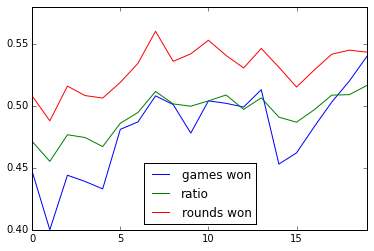

In [7]:
stats.plot()

model

In [21]:
from jassbot.utils.Logger import *

state = init()
new_game(state)
print_state(state)

suit_orders = []
for p in range(4):
    player_hand = state['p%i_hand' % p]
    trump = state['trump']
    suit_order = order_suits(player_hand, trump)
    suit_orders.append(suit_order)

for j in range(9):
    for i in range(4):
        suit_order = suit_orders[i]
    
        play_once(state, lambda (possible_cards): \
                          choose_for_test(suit_order,state,possible_cards,model))

print_state(state)

2016-06-29 22:56:24,273 - root - INFO - init game
2016-06-29 22:56:24,274 - root - INFO - new game
2016-06-29 22:56:24,275 - root - INFO - -------------------------------
2016-06-29 22:56:24,276 - root - INFO - trump: heart
2016-06-29 22:56:24,276 - root - INFO - current: []
2016-06-29 22:56:24,276 - root - INFO - player 0: ['diamond_j', 'spade_7', 'spade_j', 'diamond_10', 'heart_a', 'heart_6', 'club_a', 'diamond_9', 'club_6']
2016-06-29 22:56:24,277 - root - INFO - player 1: ['heart_k', 'club_q', 'club_8', 'diamond_6', 'heart_10', 'heart_7', 'diamond_8', 'spade_a', 'spade_k']
2016-06-29 22:56:24,277 - root - INFO - player 2: ['heart_q', 'heart_j', 'club_9', 'diamond_a', 'spade_10', 'spade_8', 'club_k', 'club_7', 'heart_8']
2016-06-29 22:56:24,278 - root - INFO - player 3: ['club_10', 'diamond_k', 'spade_9', 'diamond_q', 'spade_q', 'spade_6', 'heart_9', 'diamond_7', 'club_j']
2016-06-29 22:56:24,278 - root - INFO - team 0: 0 pts, team 1: 0 pts
2016-06-29 22:56:24,278 - root - INFO - pl

In [24]:
save_model(model, stats, "first model which gets about 55% score against the random bot")

'2016-06-29-230841'